In [1]:
import numpy as np
import pandas as pd

from scipy.stats import binom, uniform

from plotnine import ggplot, geom_line, geom_segment, geom_point
from plotnine import theme_matplotlib, scale_x_log10, scale_y_log10, scale_color_discrete
from plotnine import aes, labs, guides, guide_legend, options

In [2]:
options.figure_size = (7.4, 4.8)
joonised_kaust = 'tees/joonised/'

$\DeclareMathOperator*{\MEAN}{\mathbf{E}}$
$\DeclareMathOperator*{\VARIANCE}{\mathbf{D}}$
$\newcommand{\mean}[1]{\MEAN\left[#1\right]}$
$\newcommand{\variance}[1]{\VARIANCE\left[#1\right]}$
$\newcommand{\prob}[1]{\Pr\left[#1\right]}$
$\newcommand{\accuracy}{Acc}$
$\newcommand{\precision}{Prec}$
$\newcommand{\recall}{Rec}$

## Õigsuse lähendi absoluutne viga
Valimi põhjal leitud lähendid kvaliteedimõõtudele sisaldavad viga. Kui tahame veenduda lähendi vastavuses selle täpsele väärtusele tekib küsimus vea suuruse kohta. Vea arvutamiseks peame teadma täpset väärtust, mis ei pruugi olla võimalik. Täpset väärtust teadmata saame viga hinnata tõenäosuslikult. Standardselt seatakse eesmärgiks hinnata kui suur on viga $95\%$ juhtudest.

Üks viis vea tõenäosuslikuks hindamiseks on kasutada konsentratsioonivõrratusi, näiteks Höffdingi võrratust. Höffdingi võrratus on suurte arvude seaduse konkreetne erijuht, mis annab üldistest hinnangutest täpsemaid tõkkeid tõenäosustele. Höffdingi võrratus annab ülemise tõkke tõenäosusele, et tõkestatud paarikaupa sõltumatute juhuslike suuruste summa erineb selle summa keskväärtusest (oodatud väärtusest) vähemalt mingi konstandi võrra \cite{höffdingi-võrratus,tõenäosusteooria-2-loengukonspekt}. Täpsemalt, kui juhuslikud suurused $Z_1, Z_2, \dots, Z_N$ on sõltumatud ning leiduvad tõkked
\begin{equation*}
    a_i \leq Z_i \leq b_i \enspace, 
\end{equation*}
siis summa $S_N = Z_1 + \dots + Z_N$ ning iga positiivse $c$ korral kehtib
\begin{equation*}
    \prob{| S_N - \mean{S_N} | \geq c} \leq 2 \exp{\left( -\frac{2 c^2}{\sum_{i = 1}^{N}(b_i - a_i)^2}\right)} \enspace.
\end{equation*}

Kuna Bernoulli jaotusega juhuslike suuruste jaoks leiduvad tõkked $0 \leq Z_i \leq 1$ järeldub Höffdingi võrratusest seos
\begin{equation}
    \label{eq:höffding absoluutne viga}
    \prob{\mid \widehat{\accuracy} - \accuracy \mid \geq \frac{c}{N}} \leq 2 \exp{\left( - \frac{2 c^2}{N} \right)} \enspace,
\end{equation}
mille põhjal saame hinnata lähendi $\widehat{\accuracy}$ absoluutse vea alumise tõkke tõenäosust. Kui sätime võrratuse \eqref{eq:höffding absoluutne viga} parema poole võrdseks olulisusega $\alpha$ avaldub veahinnangu alumine tõke kujul
\begin{equation*}
     \varepsilon := \frac{c}{N} = \sqrt{- \frac{1}{2 N} \cdot \ln{\left( \frac{\alpha}{2} \right)}} \enspace.
\end{equation*}
Tulemuse põhjal saame arvutada valimi vajaliku suuruse
\begin{equation*}
    N \geq - \frac{1}{2 \varepsilon^2} \cdot \ln{\left( \frac{\alpha}{2} \right)} \enspace,
\end{equation*}
et fikseeritud olulisuse korral saavutada soovitud suurusega veahinnang.

| $1 − \alpha$ | $\varepsilon = 10\%$ | $\varepsilon = 1\%$ | $\varepsilon = 0.1\%$ |
|--------------|----------------------|---------------------|-----------------------|
| $99\% (3σ)$  | $265$                | $26492$             | $2649159$             |
| $95\% (2σ)$  | $185$                | $18445$             | $1844440$             |
| $68\% (1σ)$  | $92$                 | $9163$              | $916291$              |

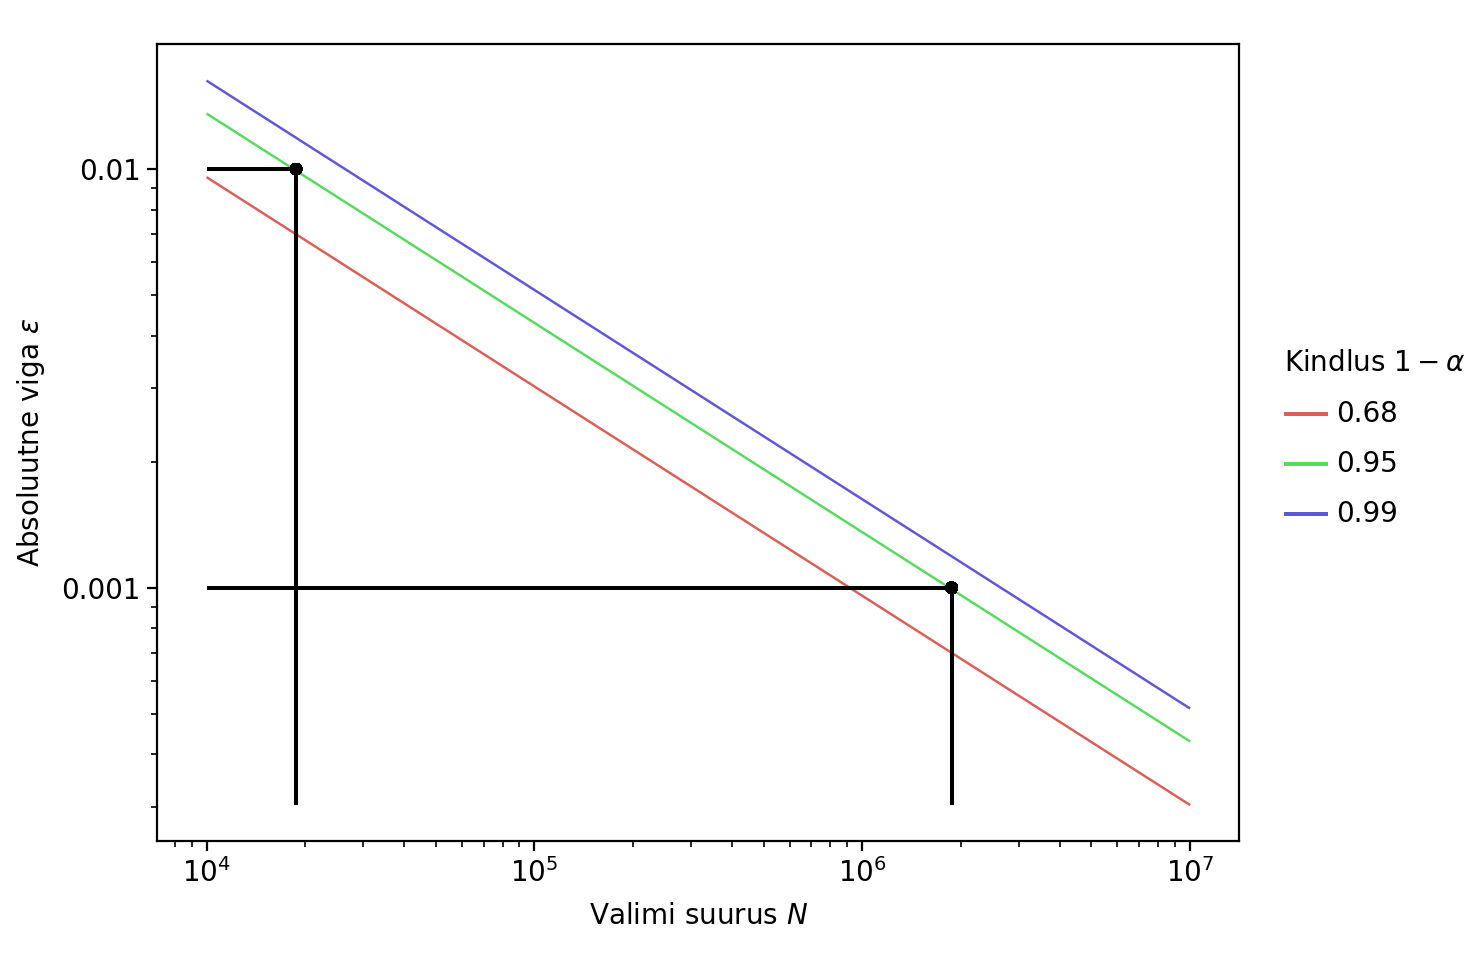

<Figure Size: (740 x 480)>

In [3]:
N = np.logspace(4, 7, 100)
olulisused = 0.01, 0.05, 0.32

read = np.array([
    (round(1 - a, 2), n, np.sqrt(-np.log(a / 2) / (2 * n)))
    for a in olulisused
    for n in N
])

df = pd.DataFrame(read, columns=['kindlus', 'n', 'epsilon'])

k95 = df.query('kindlus == .95')
n_k95_e01 = k95.iloc[np.abs(k95['epsilon'] - 0.01).argmin()]['n']
n_k95_e001 = k95.iloc[np.abs(k95['epsilon'] - 0.001).argmin()]['n']
eps_min = df['epsilon'].min()

g = (
    ggplot(df) + theme_matplotlib() +

    labs(x='Valimi suurus $N$', y='Absoluutne viga $\\varepsilon$') +
    guides(color=guide_legend(title='Kindlus $1-\\alpha$')) +
    
    scale_x_log10(breaks=np.logspace(4, 7, 4), labels=['$10^4$', '$10^5$', '$10^6$', '$10^7$']) +
    scale_y_log10(breaks=np.logspace(-3, -1, 3)) +
    
    geom_line(aes('n', 'epsilon', group='kindlus', color='pd.Categorical(kindlus)')) +
    
    geom_segment(aes(x=n_k95_e01, y=eps_min, xend=n_k95_e01, yend=1e-2)) +
    geom_segment(aes(x=n_k95_e001, y=eps_min, xend=n_k95_e001, yend=1e-3)) +
    geom_segment(aes(x=1e4, y=1e-2, xend=n_k95_e01, yend=1e-2)) +
    geom_segment(aes(x=1e4, y=1e-3, xend=n_k95_e001, yend=1e-3)) +
    
    geom_point(aes(x='n_k95_e01', y='1e-2')) + geom_point(aes(x='n_k95_e001', y='1e-3'))
)
# g.save(joonised_kaust + 'hoeffding_absoluutne_viga.png', dpi=100)
g

Tabelis on vajalik valimi suurus soovitud kindluse ja lähendi absoluutse vea suhtes Höffdingi võrratuse põhjal, kindluse puhul on sulgudes, kui mitu normaaljaotuse standardhälvet $\sigma$ keskväärtuse ümbruses see katab. Näiteks kui tahame olla $95\%$ kindlad, et valimi põhjal arvutatud õigsus $\widehat{\accuracy}$ erineb algoritmi tegelikust õigsusest kuni ühe protsendi võrra, peame õigsust hindama valimil suurusega vähemalt $18445$. Joonisel on sama mõttekäik visuaalselt.

Õigsuse lähendi absoluutse vea hindamiseks saame ka kasutada asjaolu, et suurused $Z_i$ on Bernoulli jaotusega. See tähendab, et summa
\begin{equation*}
    S_N = \sum^{N}_{i = 1} Z_i \enspace,
\end{equation*}
on binoomjaotusega. Mingi binoomjaotusega juhusliku suuruse $X$ puhul tähistatakse seda $X \sim \mathcal{B}(n, p)$, kus parameeter $n$ on Bernoulli katsete arv ja $p$ katse õnnestumise tõenäosus. Sellest lähtudes väidame järgnevat
\begin{equation*}
    S_N \sim \mathcal{B}(N, \accuracy) \enspace.
\end{equation*}
Seega on õigsuse lähend $\widehat{\accuracy}$ skaleeritud binoomjaotusega juhuslik suurus. Eespool leitud Höffdingi võrratusel põhinevad tõkked selle omadusega ei arvestanud ning olid binoomjaotuse parameetrist $p$ sõltumatud, tegu oli konservatiivse hinnanguga. Höffidngi võrratus on universaalne üle kõikide binoomjaotuse parameetrite $p$, millest halvim variant realiseerub juhul $p = 0{,}5$. Binoomjaotusel põhinevad tõkked on täpsed ning annavad aimu Höffidngi võrratuse tulemuste ebatäpsustest. Lisaks näitavad binoomjaotusel põhinevad arvutused kuidas meetodi tegelik õigsus $\accuracy$ mõjutab tulemusi.

Kasutades teadmist, et uuritav summa on binoomjaotusega leiame jaotuse parameetritest sõltuva hinnangu. Olulisuse $\alpha$ korral leiame absoluutse veahinnangu tõkke $\varepsilon$ lähtudes võrrandist
\begin{equation}
    \label{eq:binoomjaotus absoluutne viga}
    \prob{\mid \widehat{\accuracy} - \accuracy \mid \geq \varepsilon} = \alpha \enspace,
\end{equation}
valime protsendipunktid, arvud millest $S_N$ võtab väiksemaid väärtusi protsendipunktile vastava tõenäosusega, sümmeetriliselt
\begin{align*}
    \prob{\widehat{\accuracy} \leq \accuracy - \varepsilon} &= \frac{\alpha}{2} \enspace,\\
    \prob{\widehat{\accuracy} <    \accuracy + \varepsilon} &= 1 - \frac{\alpha}{2} \enspace,
\end{align*}
kui eraldame binoomjaotusega juhusliku suuruse $S_N$ ühele poole võrratuse märki jõuame tulemuseni
\begin{align*}
    \prob{S_N \leq N \cdot (\accuracy - \varepsilon)} &= \frac{\alpha}{2} \enspace,\\
    \prob{S_N < N \cdot (\accuracy + \varepsilon)} &= 1 - \frac{\alpha}{2} \enspace.
\end{align*}
Paremale poole võrratuse märki tekkinud avaldised on $S_N$ jaotuse vastavalt $\frac{\alpha}{2}$ ja $1-\frac{\alpha}{2}$ protsendipunktid, 
\begin{align*}
    q_1 &= N \cdot(\accuracy-\varepsilon) \enspace, \\
    q_2 &= N \cdot(\accuracy+\varepsilon) \enspace. \\
\end{align*}
Fikseeritud olulisuse ja binoomjaotuse parameetrite korral võime protsendipunktid arvutada kasutades $S_N$ jaotuse omadusi. 

Absoluutse vea tõkkeks $\varepsilon$ võrrandist \eqref{eq:binoomjaotus absoluutne viga} valime suurema protsentipunktide põhjal arvutatud veahinnangutest
\begin{equation}
    \label{eq:binoomjaotus absoluutne viga tõke}
    \varepsilon = \max \left( \accuracy - \frac{q_1}{N} , \frac{q_2}{N} - \accuracy \right) \enspace.
\end{equation}
Parameetri $N$ kasvades koondub binoomjaotus normaaljaotuseks \cite{tõenäosusteooria-algkursus}. Seega suuremate $N$ väärtuste puhul on binoomjaotus sümmeetriline, järelikult erinevad $q_1$ ja $q_2$ põhjal arvutatud veahinnangute väärtused tegelikkuses vähe. Tulemust \eqref{eq:binoomjaotus absoluutne viga tõke} kasutades saame arvutada vajaliku valim suuruse soovitud olulisuse suhtes, kuid selle jaoks peame oletama mudeli tegelikku õigsust $\accuracy$.

| $\accuracy$ | $\varepsilon = 10\%$ | $\varepsilon = 1\%$     | $\varepsilon = 0.1\%$     |
|-------------|----------------------|-------------------------|---------------------------|
| $70\%$      | $75\enspace(2{,}47)$ | $8100\enspace(2{,}28)$  | $806289\enspace(2{,}29)$  |
| $90\%$      | $35\enspace(5{,}29)$ | $3600\enspace(5{,}12)$  | $347020\enspace(5{,}32)$  |
| $95\%$      | $20\enspace(9)$      | $1850\enspace(9{,}97)$  | $183285\enspace(10{,}06)$ |

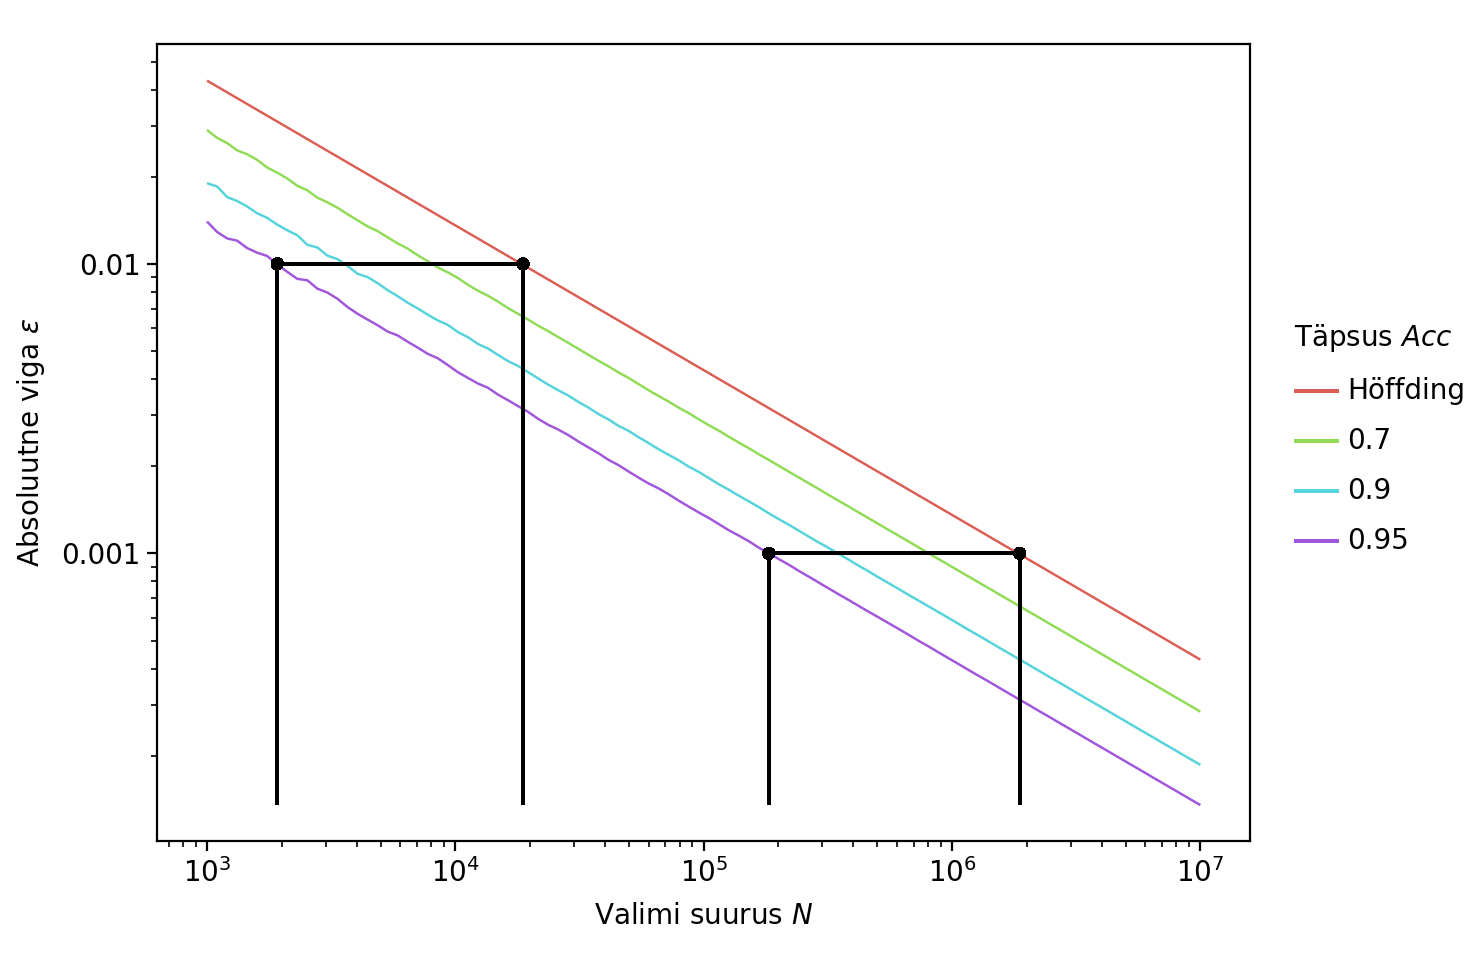

<Figure Size: (740 x 480)>

In [4]:
N = np.round(np.logspace(3, 7, 100), 0)  # binom.ppf() ei salli komakohti ???
tõenäosused = 0.7, 0.9, 0.95

read = [
    (p, n, max(p - binom.ppf(q=0.025, p=p, n=n) / n, binom.ppf(q=1 - 0.025, p=p, n=n) / n - p)) for p in tõenäosused for n in N
]  # binoom
read += [(-1, n, np.sqrt(-np.log(0.025) / (2 * n))) for n in N]  # höffding
df = pd.DataFrame(read, columns=['tõenäosus', 'n', 'epsilon'])

p95 = df.query('tõenäosus == .95')
n_p95_e01 = p95.iloc[np.abs(p95['epsilon'] - 0.01).argmin()]['n']
n_p95_e001 = p95.iloc[np.abs(p95['epsilon'] - 0.001).argmin()]['n']
eps_min = df['epsilon'].min()

g = (
    ggplot(df) + theme_matplotlib() +

    labs(x='Valimi suurus $N$', y='Absoluutne viga $\\varepsilon$') +
    guides(color=guide_legend(title='Täpsus $Acc$')) +
    
    scale_x_log10(breaks=np.logspace(3, 7, 5), labels=['$10^3$','$10^4$', '$10^5$', '$10^6$', '$10^7$']) +
    scale_y_log10(breaks=np.logspace(-3, -1, 3)) +
    scale_color_discrete(labels=['Höffding', 0.7, 0.9, 0.95]) +

    geom_line(aes('n', 'epsilon', group='tõenäosus', color='pd.Categorical(tõenäosus)')) +
    
    geom_segment(aes(x=n_k95_e01, y=eps_min, xend=n_k95_e01, yend=1e-2)) +
    geom_segment(aes(x=n_k95_e001, y=eps_min, xend=n_k95_e001, yend=1e-3)) +
    geom_segment(aes(x=n_p95_e01, y=eps_min, xend=n_p95_e01, yend=1e-2)) +
    geom_segment(aes(x=n_p95_e001, y=eps_min, xend=n_p95_e001, yend=1e-3)) +
    geom_segment(aes(x=n_p95_e01, y=1e-2, xend=n_k95_e01, yend=1e-2)) +
    geom_segment(aes(x=n_p95_e001, y=1e-3, xend=n_k95_e001, yend=1e-3)) +
    
    geom_point(aes(x='n_p95_e01', y='1e-2')) + geom_point(aes(x='n_p95_e001', y='1e-3')) +
    geom_point(aes(x='n_k95_e01', y='1e-2')) + geom_point(aes(x='n_k95_e001', y='1e-3'))
)
# g.save(joonised_kaust + 'binoomjaotus_absoluutne_viga.png', dpi=100)
g

Tabelis ja joonisel on valimi vajalikud suurused meetodi oletatud õigsuse ja absoluutse veahinnangu soovitud suuruse suhtes binoomjaotuse omaduste põhjal kindlusega $95\%$. Võrdluseks on olemas ka Höffdingi võrratusel põhinevad tulemused sama kindlusega, joonisel eraldi joonena, tabelis on sulgudes kirjas kui mitu korda on Höffdingi võrratuse põhine valim suurem. Eeldusel, et algoritmi tegelik õigsus on $90\%$, absoluutse vea kuni üks protsent jaoks vajame valimit suurusega vähemalt $3600$, mis on umbes viis korda väiksem kui valim, mida vajasime Höffdingi võrratuse põhjal.